# Detecting depression in Tweets using Baye's Theorem

# Installing and importing libraries

In [1]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Loading the Data

In [2]:
tweets = pd.read_csv('sentiment_tweets3.csv')
tweets.head(20)

,Unnamed: 0,message,label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
5,624,so sleepy. good times tonight though,0
6,701,"@SilkCharm re: #nbn as someone already said, d...",0
7,808,23 or 24ï¿½C possible today. Nice,0
8,1193,nite twitterville workout in the am -ciao,0
9,1324,"@daNanner Night, darlin'! Sweet dreams to you",0


In [3]:
tweets.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [4]:
tweets['label'].value_counts()

0    8000
1    2314
Name: label, dtype: int64

### The dataset has
* 8000 positive tweets
* 2314 negative (depressive) tweets

In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10314 non-null  object
 1   label    10314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.3+ KB


# Splitting the Data in Training and Testing Sets

As you can see, I used almost all the data for training: 98% and the rest for testing.

In [6]:
totalTweets = 8000 + 2314
trainIndex, testIndex = list(), list()
for i in range(tweets.shape[0]):
    if np.random.uniform(0, 1) < 0.98:
        trainIndex += [i]
    else:
        testIndex += [i]
trainData = tweets.iloc[trainIndex]
testData = tweets.iloc[testIndex]

### Randomly splitting the data into train and test
* 98% training
* 2 % testing

**Approach chosen because of unpredictability and lack of sufficient data**

In [7]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10314 non-null  object
 1   label    10314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.3+ KB


In [8]:
trainData['label'].value_counts()

0    7855
1    2281
Name: label, dtype: int64

### <font color='blue'>Randomization gave a good distribution in training set</font>

In [9]:
trainData.tail(15)

,message,label
10299,Engaging in physical activity decreases people...,1
10300,"depression: i'm always here for u, darling",1
10301,"I'm suffering from depression, I'm thankful th...",1
10302,More than one in 20 US children and teens have...,1
10303,IM GOING TO SEE @HayleyKiyoko NEXT WEEK IN CHI...,1
10304,"Reagan, Bush 43 & Trump, all GOP, all used MAG...",1
10305,RT Depression Could Be Improved With Vitamin D...,1
10306,actors symptoms of adult depression naked gtee...,1
10307,@GaindaSwamy @Kanatungaa @Being_Humor @theskin...,1
10308,Many sufferers of depression aren't sad; they ...,1


In [10]:
testData['label'].value_counts()

0    145
1     33
Name: label, dtype: int64

In [11]:
testData.head()

,message,label
50,@EmmaLight I'd forgotten about that We need t...,0
73,Is in Athens,0
130,"Time for a shower and french toast. No, not to...",0
134,thinks that Kellan Lutz is hot when he smokes,0
158,@KimKardashian hey kim im a huge fan! ur lik...,0


# Wordcloud Analysis

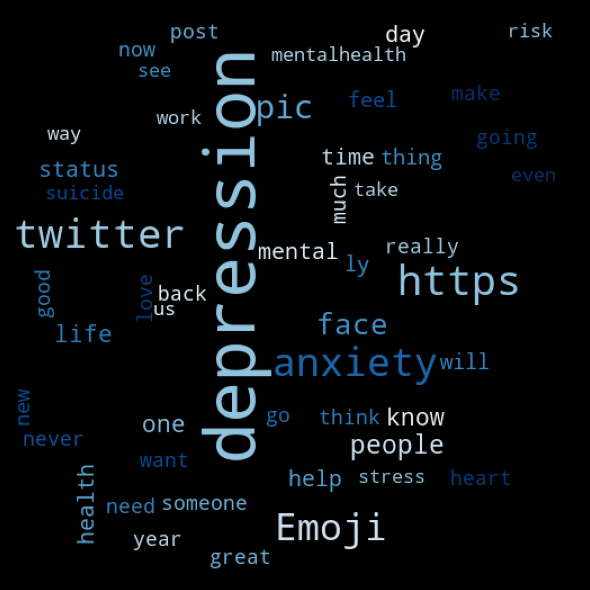

In [12]:
depressive_words = ' '.join(list(tweets[tweets['label'] == 1]['message']))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues", max_words=50).generate(depressive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## <font color='red'> As expected, negative tweets show depressing words</font>

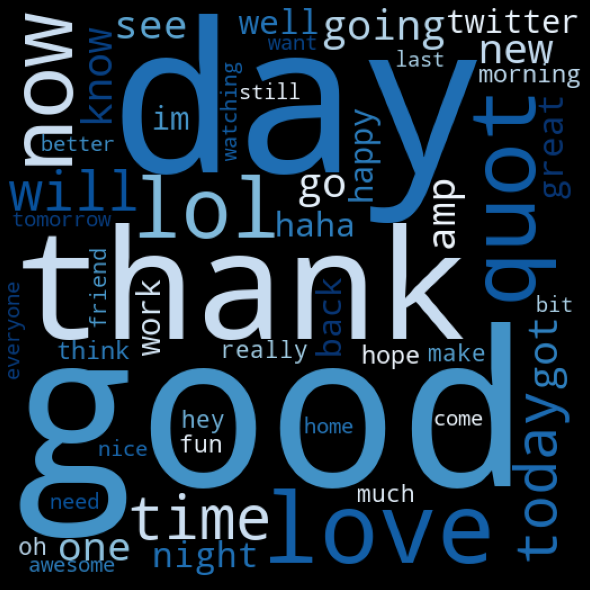

In [13]:
positive_words = ' '.join(list(tweets[tweets['label'] == 0]['message']))
positive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues", max_words=50).generate(positive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(positive_wc)
plt.axis('off'), 
plt.tight_layout(pad = 0)
plt.show()

## <font color='green'> As expected, positive tweets show mostly positive feelings</font>

#Pre-processing the data for the training: Tokenization, stemming, and removal of stop words

In [14]:
ps = PorterStemmer()
sw = stopwords.words('english')

### Process tweet text to generate bigrams

In [15]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    # generating bigrams from the message
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if stop_words:
        words = [word for word in words if word not in sw]
    if stem:
        words = [ps.stem(word) for word in words]
    bigrm = list(nltk.bigrams(words))
    bigrams = [' '.join(x) for x in bigrm]
    return bigrams
# Returns single message with preprocessing

In [16]:
class TweetClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.tweets, self.labels = trainData['message'], trainData['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word] + 1) / (self.depressive_words + \
                                                                len(list(self.tf_depressive.keys())))
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word] + 1) / (self.positive_words + \
                                                                len(list(self.tf_positive.keys())))
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 


    def calc_TF_and_IDF(self):
        noOfMessages = self.tweets.shape[0]
        self.depressive_tweets, self.positive_tweets = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_tweets = self.depressive_tweets + self.positive_tweets
        self.depressive_words = 0
        self.positive_words = 0
        self.tf_depressive = dict()
        self.tf_positive = dict()
        self.idf_depressive = dict()
        self.idf_positive = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.tweets.iloc[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels.iloc[i]:
                    # If negative tweet, then 
                    self.tf_depressive[word] = self.tf_depressive.get(word, 0) + 1
                    # Increase dictionary value of word by 1
                    self.depressive_words += 1
                    # Increment depressive word counter
                else:
                    self.tf_positive[word] = self.tf_positive.get(word, 0) + 1
                    self.positive_words += 1
                if word not in count:
                    count += [word]
                    # Add word to count so not processed again
                    
            for word in count:
                if self.labels.iloc[i]:
                    self.idf_depressive[word] = self.idf_depressive.get(word, 0) + 1
                else:
                    self.idf_positive[word] = self.idf_positive.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        self.sum_tf_idf_depressive = 0
        self.sum_tf_idf_positive = 0
        for word in self.tf_depressive:
            # loop through depressive words and calculate probability.
            self.prob_depressive[word] = (self.tf_depressive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive[word] + self.idf_positive.get(word, 0)))
            # Keep track of probability so far
            
            self.sum_tf_idf_depressive += self.prob_depressive[word]
        
        for word in self.tf_depressive:
            # Loop through depressive words and apply Laplacian Correction
            self.prob_depressive[word] = (self.prob_depressive[word] + 1) / (self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
            
        for word in self.tf_positive:
            # Loop through all positive words
            self.prob_positive[word] = (self.tf_positive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive.get(word, 0) + self.idf_positive[word]))
            self.sum_tf_idf_positive += self.prob_positive[word]
            
        for word in self.tf_positive:
            # Apply laplacian correction
            self.prob_positive[word] = (self.prob_positive[word] + 1) / (self.sum_tf_idf_positive + len(list(self.prob_positive.keys())))
            
        # Calculate final numerical probability
        
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 
        
        
    def classify(self, processed_message, flag):
        pDepressive, pPositive = 0, 0
        for word in processed_message: 
            # Looping through every word
            # If depressive word
            if word in self.prob_depressive:
                pDepressive += log(self.prob_depressive[word])
            else:
                if self.method == 'tf-idf':
                    # Calcluate actual TF-IDF score.
                    pDepressive -= log(self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
                    if flag:
                        print(pDepressive)
                else:
                    pDepressive -= log(self.depressive_words + len(list(self.prob_depressive.keys())))
            # If positive word
            if word in self.prob_positive:
                pPositive += log(self.prob_positive[word])
            else:
                if self.method == 'tf-idf':
                    pPositive -= log(self.sum_tf_idf_positive + len(list(self.prob_positive.keys()))) 
                    if flag:
                        print(pPositive)
                else:
                    pPositive -= log(self.positive_words + len(list(self.prob_positive.keys())))
            pDepressive += log(self.prob_depressive_tweet)
            pPositive += log(self.prob_positive_tweet)
            
        # Return boolean by comparing probabilities
        return pDepressive >= pPositive
    
    def predict(self, testData):
        result = dict()
        flag = False
        for (i, message) in enumerate(testData):
            if i%100==0:
                flag = True
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message, flag))
        return result

### Defining all variables

In [17]:
ttrain, ltrain = trainData['message'], trainData['label']
prob_depressive = dict()
prob_positive = dict()
sum_tf_idf_depressive = 0
sum_tf_idf_positive = 0

### Defining Methods

In [18]:
def trainbuild():
    noOfTweets = ttrain.shape[0]
    depressive_tweets, positive_tweets = ltrain.value_counts()[1], ltrain.value_counts()[0]
    total_tweets = depressive_tweets + positive_tweets
    depressive_words = 0
    positive_words = 0
    tf_depressive = dict()
    tf_positive = dict()
    idf_depressive = dict()
    idf_positive = dict()
    for i in range(noOfTweets):
        if i%1000==0:
            print(ttrain.iloc[i])
            message_processed = process_message(ttrain.iloc[i])
            count = list() 
            #To keep track of whether the word has ocured in the message or not.
            #For IDF
            for bigram in message_processed:
                if ltrain.iloc[i]:
                    # If negative tweet, then 
                    tf_depressive[bigram] = tf_depressive.get(bigram, 0) + 1
                    # Increase dictionary value of word by 1
                    depressive_words += 1
                    # Increment depressive word counter
                else:
                    # Similarly for positive words
                    tf_positive[bigram] = tf_positive.get(bigram, 0) + 1
                    positive_words += 1
                if bigram not in count:
                    count += [bigram]
                    # Add word to count so not processed again
            if i%1000==0:
                print(count)
            for bigram in count:
                # for every bigram occuring in the current message
                # if label is positive, increment counter for 
                if ltrain.iloc[i]:
                    idf_depressive[bigram] = idf_depressive.get(bigram, 0) + 1
                else:
                    idf_positive[bigram] = idf_positive.get(bigram, 0) + 1

In [19]:
trainbuild()

just had a real good moment. i missssssssss him so much, 
['real good', 'good moment', 'moment missssssssss', 'missssssssss much']
and so another week begins. this one has got to be better than the last 
['anoth week', 'week begin', 'begin one', 'one got', 'got better', 'better last']
@jaybranch Thanks so much for the #followfriday!   
['jaybranch thank', 'thank much', 'much followfriday']
sau saal jiyo tum jaan meri  http://bit.ly/Pj27i  the lovely voice of Dilraj Kaur, sounds so much like Ashaji.. 
['sau saal', 'saal jiyo', 'jiyo tum', 'tum jaan', 'jaan meri', 'meri http', 'http //bit.ly/pj27i', '//bit.ly/pj27i love', 'love voic', 'voic dilraj', 'dilraj kaur', 'kaur sound', 'sound much', 'much like', 'like ashaji..']
Happy 50th Update Thing  who wants to party in my pants? ;)
['happi 50th', '50th updat', 'updat thing', 'thing want', 'want parti', 'parti pant']
girls in bed, watching Alias and getting ready to raid the fridge - blueberries, here I come 
['girl bed', 'bed watch', 'watc

In [20]:
def calc_TF_IDF():
        prob_depressive = dict()
        prob_positive = dict()
        sum_tf_idf_depressive = 0
        sum_tf_idf_positive = 0
        for bigram in tf_depressive:
            
            # loop through depressive bigrams and calculate probability.
            prob_depressive[bigram] = (tf_depressive[bigram]) * log((noOfTweets) \
                                                          / (idf_depressive[bigram] + idf_positive.get(bigram, 0)))
            # Keep track of probability so far
            
            sum_tf_idf_depressive += prob_depressive[bigram]
        
        for bigram in tf_depressive:
            # Loop through depressive bigrams and apply Laplacian Correction
            prob_depressive[bigram] = (prob_depressive[bigram] + 1) / (sum_tf_idf_depressive + len(list(prob_depressive.keys())))
            
        for bigram in tf_positive:
            # Loop through all positive bigrams
            prob_positive[bigram] = (tf_positive[bigram]) * log((noOfTweets) \
                                                          / (idf_depressive.get(bigram, 0) + idf_positive[bigram]))
            sum_tf_idf_positive += prob_positive[bigram]
            
        for bigram in tf_positive:
            # Apply laplacian correction
            prob_positive[bigram] = (prob_positive[bigram] + 1) / (sum_tf_idf_positive + len(list(prob_positive.keys())))
            
        # Calculate final numerical probability
        prob_depressive_tweet, prob_positive_tweet = depressive_tweets / total_tweets, positive_tweets / total_tweets 


**Prob of depressive bigram = (freq of <i>depressive</i> bigram)* log(N/sum of idf counts)** 

In [21]:
def classify(processed_message):
        pDepressive, pPositive = 0, 0
        for bigram in processed_message: 
            # Looping through every bigram
            # If depressive bigram
            if bigram in prob_depressive:
                pDepressive += log(prob_depressive[bigram])
            else:
                if method == 'tf-idf':
                    # Calcluate actual TF-IDF score.
                    pDepressive -= log(sum_tf_idf_depressive + len(list(prob_depressive.keys())))
                else:
                    pDepressive -= log(depressive_bigrams + len(list(prob_depressive.keys())))
            # If positive bigram
            if bigram in prob_positive:
                pPositive += log(prob_positive[bigram])
            else:
                if method == 'tf-idf':
                    pPositive -= log(sum_tf_idf_positive + len(list(prob_positive.keys()))) 
                else:
                    pPositive -= log(positive_bigrams + len(list(prob_positive.keys())))
            pDepressive += log(prob_depressive_tweet)
            pPositive += log(prob_positive_tweet)
            
        # Return boolean by comparing probabilities
        return pDepressive >= pPositive

In [22]:
def bagofbigrams_build():
        prob_depressive = dict()
        prob_positive = dict()
        for bigram in tf_depressive:
            prob_depressive[bigram] = (tf_depressive[bigram] + 1) / (depressive_bigrams + \
                                                                len(list(tf_depressive.keys())))
        for bigram in tf_positive:
            prob_positive[bigram] = (tf_positive[bigram] + 1) / (positive_bigrams + \
                                                                len(list(tf_positive.keys())))
        prob_depressive_tweet, prob_positive_tweet = depressive_tweets / total_tweets, positive_tweets / total_tweets

In [23]:
sc_tf_idf = TweetClassifier(trainData, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['message'])

-12.534636551560837
-13.117738011581618
-26.56075260283826
-26.49041919447449
-40.58686865411568
-39.86310037736736
-12.534636551560837
-13.117738011581618
-26.56075260283826
-26.49041919447449
-40.58686865411568
-54.61298470539311
-50.34200432520706
-12.534636551560837
-13.117738011581618
-26.56075260283826
-26.49041919447449
-40.58686865411568
-39.86310037736736
-54.61298470539311
-53.235781560260236
-12.534636551560837
-13.117738011581618
-26.56075260283826
-26.49041919447449
-40.58686865411568
-39.86310037736736
-54.61298470539311
-53.235781560260236
-68.63910075667053
-66.60846274315311
-82.66521680794796
-79.98114392604599
-107.90353179867667
-103.9125891800056
-121.9296478499541
-135.95576390123153
-128.33322844462703
-149.98187995250896
-141.7059096275199
-164.0079960037864
-155.07859081041278
-13.117738011581618
-12.534636551560837
-26.56075260283826
-40.58686865411568
-54.61298470539311
-46.26161225676732
-68.63910075667053
-59.6342934396602
-82.66521680794796
-73.00697462255

-26.49041919447449
-38.26214555295138
-39.86310037736736
-12.534636551560837
-13.117738011581618
-26.56075260283826
-26.49041919447449
-40.58686865411568
-39.86310037736736
-12.534636551560837
-13.117738011581618
-26.56075260283826
-26.49041919447449
-40.58686865411568
-39.86310037736736
-54.61298470539311
-68.63910075667053
-82.66521680794796
-74.42262843520109
-12.534636551560837
-13.117738011581618
-26.56075260283826
-26.49041919447449
-40.58686865411568
-39.86310037736736
-53.235781560260236
-66.31437765550623
-66.60846274315311
-12.534636551560837
-26.56075260283826
-21.843913609817292
-40.58686865411568
-35.21659479271017
-54.61298470539311
-68.63910075667053
-59.63723405733161
-82.66521680794796
-73.00991524022449
-96.69133285922538
-86.38259642311736
-110.71744891050281
-99.75527760601024
-124.74356496178024
-113.12795878890311
-138.76968101305766
-126.50063997179599
-152.7957970643351
-139.87332115468885
-166.82191311561252
-153.24600233758173
-12.534636551560837
-13.117738011

-13.117738011581618
-26.56075260283826
-26.49041919447449
-40.58686865411568
-39.86310037736736
-54.61298470539311
-53.235781560260236
-68.63910075667053
-66.60846274315311
-82.66521680794796
-79.98114392604599
-96.69133285922538
-93.35382510893886
-110.71744891050281
-124.74356496178024
-117.7744643735603
-12.534636551560837
-13.117738011581618
-26.56075260283826
-26.49041919447449
-40.58686865411568
-54.61298470539311
-50.911058459095926
-68.63910075667053
-64.2837396419888
-82.66521680794796
-77.65642082488168
-12.534636551560837
-13.117738011581618
-12.534636551560837
-13.117738011581618
-12.534636551560837
-13.117738011581618
-26.56075260283826
-26.49041919447449
-40.58686865411568
-39.86310037736736
-65.8251836448444
-63.79454563132697
-79.85129969612183
-77.16722681421984
-93.87741574739925
-90.53990799711272
-107.90353179867668
-103.9125891800056
-121.92964784995411
-117.28527036289847
-135.95576390123153
-130.65795154579135
-12.534636551560837
-13.117738011581618
-26.560752602

-24.16569609331019
-40.58686865411568
-37.538377276203065
-12.534636551560837
-13.117738011581618
-26.56075260283826
-26.49041919447449
-12.534636551560837
-13.117738011581618
-26.56075260283826
-26.49041919447449
-40.58686865411568
-39.86310037736736
-54.61298470539311
-68.63910075667053
-62.7887187348428
-82.66521680794796
-76.16139991773568
-96.69133285922538
-89.53408110062855
-110.71744891050281
-124.74356496178024
-138.76968101305766
-12.534636551560837
-13.117738011581618
-26.56075260283826
-26.49041919447449
-40.58686865411568
-39.86310037736736
-54.61298470539311
-53.235781560260236
-68.63910075667053
-66.60846274315311
-82.66521680794796
-79.98114392604599
-96.69133285922538
-93.35382510893886
-110.71744891050281
-106.72650629183174
-124.74356496178024
-120.09918747472462
-138.76968101305766
-133.47186865761748
-36.32955984939755
-32.69606266719835
-12.534636551560837
-13.117738011581618
-26.56075260283826
-26.49041919447449
-40.58686865411568
-39.86310037736736
-54.612984705

-106.72650629183174
-120.09918747472462
-130.50299862351096
-133.47186865761748
-144.5291146747884
-146.84454984051035
-158.55523072606582
-160.21723102340323
-173.5899122062961
-183.37367043894005
-186.96259338918898
-197.39978649021748
-200.33527457208186
-211.4259025414949
-213.70795575497473
-225.45201859277233
-227.0806369378676
-239.47813464404976
-240.45331812076049
-253.5042506953272
-253.82599930365336
-267.5303667466046
-267.1986804865462
-281.55648279788204
-280.57136166943906
-293.9440428523319
-307.2839917992726
-307.31672403522475
-321.31010785055
-320.6894052181176
-335.33622390182745
-334.06208640101045
-347.4347675839033
-361.063732903218
-360.80744876679614
-12.534636551560837
-13.117738011581618
-26.56075260283826
-26.49041919447449
-39.86310037736736
-51.719207470339924
-53.235781560260236
-65.74532352161735
-12.534636551560837
-13.117738011581618
-26.56075260283826
-40.58686865411568
-37.538377276203065
-54.61298470539311
-50.91105845909594
-64.28373964198882
-77.6

In [26]:
# from pprint import pprint
print(classification_report (testData['label'], list(preds_tf_idf.values()) ))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       145
           1       0.77      0.52      0.62        33

    accuracy                           0.88       178
   macro avg       0.84      0.74      0.77       178
weighted avg       0.87      0.88      0.87       178



### <font color='blue'>Applying TF-IDF gives an Accuracy of 85%</font>

In [27]:
sc_bow = TweetClassifier(trainData, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(testData['message'])

In [28]:
print(classification_report (testData['label'], list(preds_bow.values())))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       145
           1       0.73      0.33      0.46        33

    accuracy                           0.85       178
   macro avg       0.80      0.65      0.69       178
weighted avg       0.84      0.85      0.83       178



### <font color='red'>Bag of Words model gives an Accuracy of 80%</font>

# Predictions with TF-IDF

# Depressive Tweets

In [29]:
pm = process_message('Lately I have been feeling unsure of myself as a person & an artist')
sc_tf_idf.classify(pm)

TypeError: classify() missing 1 required positional argument: 'flag'

In [30]:
pm = process_message('Extreme sadness, lack of energy, hopelessness')
sc_tf_idf.classify(pm)


TypeError: classify() missing 1 required positional argument: 'flag'

In [31]:
pm = process_message('Hi hello depression and anxiety are the worst')
sc_tf_idf.classify(pm)

TypeError: classify() missing 1 required positional argument: 'flag'

In [32]:
pm = process_message('I am officially done with @kanyewest')
sc_tf_idf.classify(pm)


TypeError: classify() missing 1 required positional argument: 'flag'

In [33]:
pm = process_message('Feeling down...')
sc_tf_idf.classify(pm)


TypeError: classify() missing 1 required positional argument: 'flag'

In [34]:
pm = process_message('I am feeling sad and lonely')
sc_tf_idf.classify(pm)


TypeError: classify() missing 1 required positional argument: 'flag'

# Positive Tweets

In [35]:
pm = process_message('Loving how me and my lovely partner is talking about what we want.')
sc_tf_idf.classify(pm)


TypeError: classify() missing 1 required positional argument: 'flag'

In [36]:
pm = process_message('Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits')
sc_tf_idf.classify(pm)


TypeError: classify() missing 1 required positional argument: 'flag'

In [37]:
pm = process_message('Happy Thursday everyone. Thought today was Wednesday so super happy tomorrow is Friday yayyyyy')
sc_tf_idf.classify(pm)

TypeError: classify() missing 1 required positional argument: 'flag'

In [38]:
pm = process_message('It’s the little things that make me smile. Got our new car today and this arrived with it')
sc_tf_idf.classify(pm)

TypeError: classify() missing 1 required positional argument: 'flag'

# Predictions with Bag-of-Words (BOW)

# Depressive tweets

In [39]:
pm = process_message('Hi hello depression and anxiety are the worst')
sc_bow.classify(pm)

TypeError: classify() missing 1 required positional argument: 'flag'

In [40]:
pm = process_message('My depression will not let me work out')
sc_bow.classify(pm)

TypeError: classify() missing 1 required positional argument: 'flag'

In [41]:
pm = process_message('Feeling down...')
sc_bow.classify(pm)

TypeError: classify() missing 1 required positional argument: 'flag'

# Positive Tweets

In [42]:
pm = process_message('Loving how me and my lovely partner is talking about what we want.')
sc_bow.classify(pm)

TypeError: classify() missing 1 required positional argument: 'flag'

In [43]:
pm = process_message('Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits')
sc_bow.classify(pm)

TypeError: classify() missing 1 required positional argument: 'flag'

In [44]:
pm = process_message('Happy Thursday everyone. Thought today was Wednesday so super happy tomorrow is Friday yayyyyy')
sc_bow.classify(pm)

TypeError: classify() missing 1 required positional argument: 'flag'